In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.3 MB/s eta 0:00:00


No Options

In [6]:
import os

def load_data(path, label):
    data = []
    labels = []

    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        try:
            sample = np.loadtxt(filepath)  # Assure-toi que les fichiers sont bien au format attendu
            data.append(sample)
            labels.append(label)
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {filename}: {e}")

    return np.array(data), np.array(labels)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6117 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6552 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6458 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6304 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6146 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6415 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6595 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6402 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6522 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Evaluation Metrics:
Test Accuracy:  0.7
Test Recall (Weighted):  0.7
Test Precision (Weighted):  0.48999999999999994
Test F1 Score (Weighted):  0.5764705882352941
Sensitivity:  0.0
Specificity:  1.0
Confusion Matrix: 
 [[63  0]
 [27  0]]
Training Duration (in seconds):  656.1598522663116


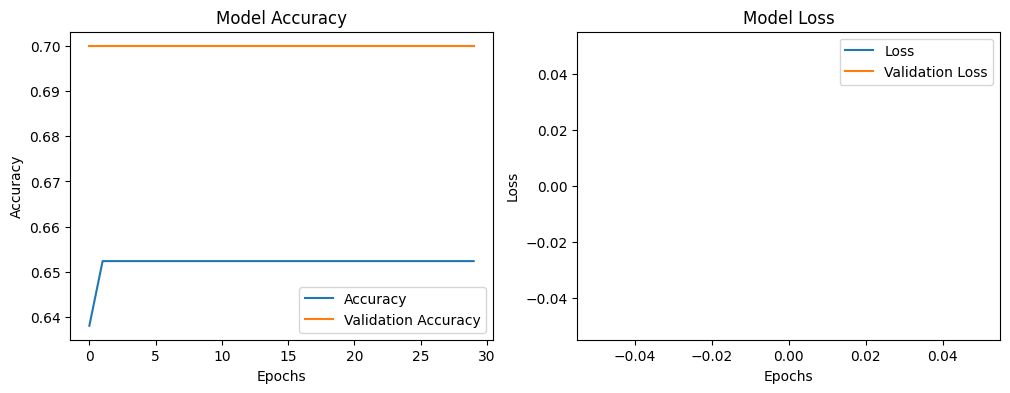

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/No_Options.keras ✅


In [8]:
import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure

# Load data with wavelet decomposition
data_Healthy, labels_Healthy = load_data(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Sensitivity (Recall for positive class)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    # Specificity (Recall for negative class)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


Standardization Added

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4976 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6257 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6550 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6721 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6593 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6231 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6988 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6711 - loss: nan - val_accuracy: 0.7000 - val_loss: nan
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6622 

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Evaluation Metrics:
Test Accuracy:  0.7
Test Recall (Weighted):  0.7
Test Precision (Weighted):  0.48999999999999994
Test F1 Score (Weighted):  0.5764705882352941
Sensitivity:  0.0
Specificity:  1.0
Confusion Matrix: 
 [[63  0]
 [27  0]]
Training Duration (in seconds):  646.3715808391571


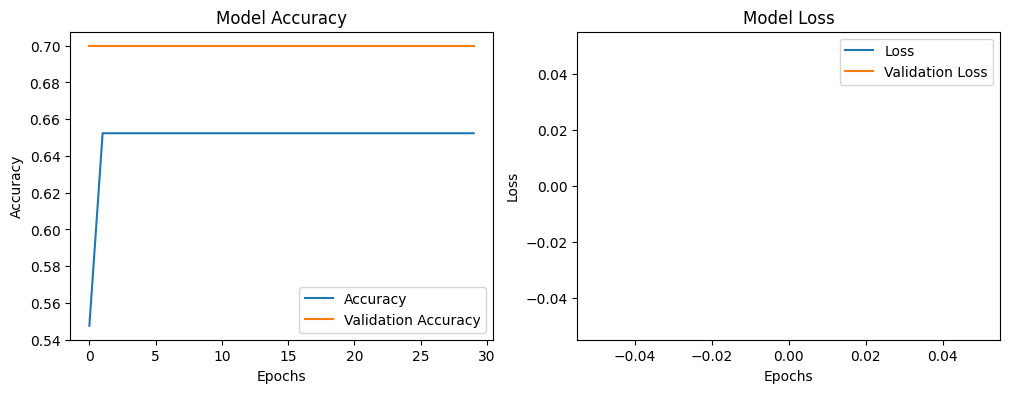

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/With_Stander.keras ✅


In [7]:
import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure

# Load data with wavelet decomposition
data_Healthy, labels_Healthy = load_data(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all)

    # Standardization: Normalize the dataset
    scaler = StandardScaler()
    data_all = scaler.fit_transform(data_all)  # Standardize the data

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Sensitivity (Recall for positive class)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    # Specificity (Recall for negative class)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


Optimiser Added

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.6317 - loss: 0.6771 - val_accuracy: 0.7000 - val_loss: 0.6227
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.7143 - loss: 0.6140 - val_accuracy: 0.7000 - val_loss: 0.6175
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6850 - loss: 0.6202 - val_accuracy: 0.7000 - val_loss: 0.6360
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.6630 - loss: 0.6449 - val_accuracy: 0.7000 - val_loss: 0.6325
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6583 - loss: 0.6488 - val_accuracy: 0.7000 - val_loss: 0.6264
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6330 - loss: 0.6564 - val_accuracy: 0.7000 - val_loss: 0.6206
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6598 - loss: 0.6426 - val_accuracy: 0.7000 - val_loss: 0.6187
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.5928 - loss: 0.6919 - val_accuracy: 0.7000 - val_loss: 0.6233
Epo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


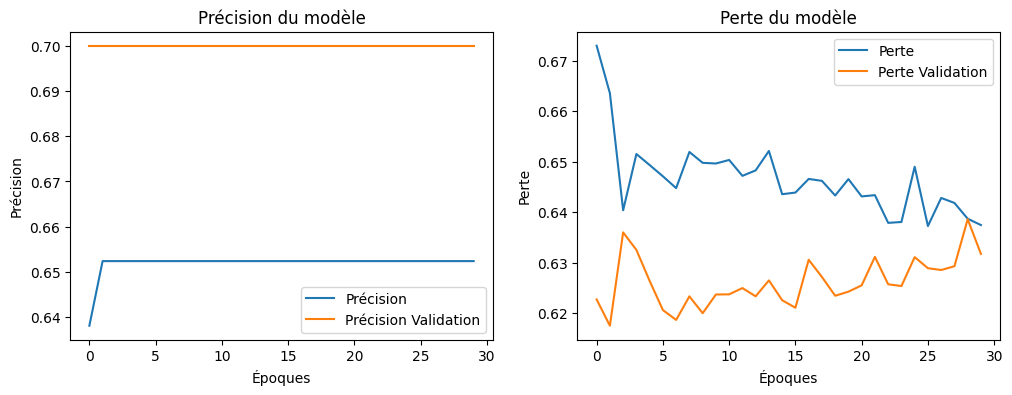

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/With_Optimiser.keras ✅


In [5]:
import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concaténer tous les coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Chargement des données (Remplacez cette fonction par votre propre implémentation)
def load_data(path, label):
    # Assurez-vous que cette fonction charge correctement vos données EEG
    data = np.random.rand(100, 256)  # Exemple de données fictives
    labels = np.full((100,), label)
    return data, labels

# Chemins vers vos datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Chargement des données avec décomposition par ondelettes
data_Healthy, labels_Healthy = load_data(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combinaison des données
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Application de la transformation par ondelettes (sans standardisation)
    data_all = wavelet_decompose(data_all)

    # Encodage one-hot des labels
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Division en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape pour l'entrée CNN-LSTM (ajout d'une dimension pour Conv1D)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Définition du modèle CNN-LSTM
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Classification binaire
    ])

    # Compilation du modèle avec Adam
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Évaluation du modèle
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Sensibilité (Recall pour la classe positive)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    # Spécificité (Recall pour la classe négative)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    print("\nÉvaluation finale :")
    print("Précision du test: ", accuracy)
    print("Recall (moyenne pondérée): ", recall)
    print("Précision (moyenne pondérée): ", precision)
    print("Score F1 (moyenne pondérée): ", f1)
    print("Sensibilité: ", sensitivity)
    print("Spécificité: ", specificity)
    print("Matrice de confusion: \n", conf_matrix)
    print("Durée de l'entraînement (secondes): ", training_duration)

    # Affichage de l'historique d'entraînement
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Précision')
    plt.plot(history.history['val_accuracy'], label='Précision Validation')
    plt.title('Précision du modèle')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perte')
    plt.plot(history.history['val_loss'], label='Perte Validation')
    plt.title('Perte du modèle')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.show()

else:
    print("Erreur: Échec du chargement des données. Vérifiez les fichiers dans les répertoires.")


       # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



Standardization + Adam Added

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - accuracy: 0.6069 - loss: 0.6682 - val_accuracy: 0.7000 - val_loss: 0.6045
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.6705 - loss: 0.6299 - val_accuracy: 0.7000 - val_loss: 0.6172
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.6672 - loss: 0.6390 - val_accuracy: 0.7000 - val_loss: 0.6097
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.6634 - loss: 0.6341 - val_accuracy: 0.7000 - val_loss: 0.6046
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.6537 - loss: 0.6513 - val_accuracy: 0.7000 - val_loss: 0.6164
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.6562 - loss: 0.6374 - val_accuracy: 0.7000 - val_loss: 0.6085
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6381 - loss: 0.6564 - val_accuracy: 0.7000 - val_loss: 0.6071
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6576 - loss: 0.6486 - val_accuracy: 0.7000 - val_loss:

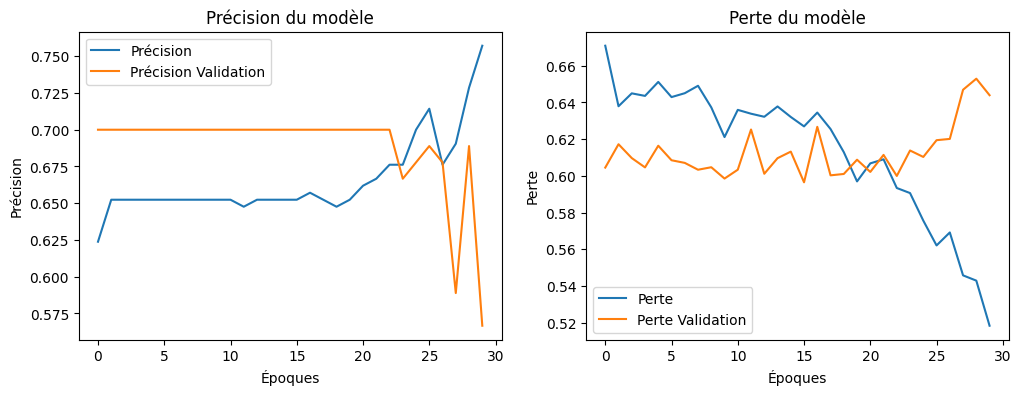

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/With_Options.keras ✅


In [4]:
import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concaténer tous les coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Chargement des données (Remplacez cette fonction par votre propre implémentation)
def load_data(path, label):
    # Assurez-vous que cette fonction charge correctement vos données EEG
    data = np.random.rand(100, 256)  # Exemple de données fictives
    labels = np.full((100,), label)
    return data, labels

# Chemins vers vos datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Chargement des données avec décomposition par ondelettes
data_Healthy, labels_Healthy = load_data(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combinaison des données
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Application de la transformation par ondelettes
    data_all = wavelet_decompose(data_all)

    # Standardisation des données
    scaler = StandardScaler()
    data_all = scaler.fit_transform(data_all)

    # Encodage one-hot des labels
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Division en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape pour l'entrée CNN-LSTM (ajout d'une dimension pour Conv1D)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Définition du modèle CNN-LSTM
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Classification binaire
    ])

    # Compilation du modèle avec Adam
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Évaluation du modèle
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Sensibilité (Recall pour la classe positive)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    # Spécificité (Recall pour la classe négative)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    print("\nÉvaluation finale :")
    print("Précision du test: ", accuracy)
    print("Recall (moyenne pondérée): ", recall)
    print("Précision (moyenne pondérée): ", precision)
    print("Score F1 (moyenne pondérée): ", f1)
    print("Sensibilité: ", sensitivity)
    print("Spécificité: ", specificity)
    print("Matrice de confusion: \n", conf_matrix)
    print("Durée de l'entraînement (secondes): ", training_duration)

    # Affichage de l'historique d'entraînement
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Précision')
    plt.plot(history.history['val_accuracy'], label='Précision Validation')
    plt.title('Précision du modèle')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perte')
    plt.plot(history.history['val_loss'], label='Perte Validation')
    plt.title('Perte du modèle')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.show()

else:
    print("Erreur: Échec du chargement des données. Vérifiez les fichiers dans les répertoires.")



     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp5/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


